# Ridge regression model
The first model will be using linear regression with ridge regularization. To evaluate the model performance, I use the MAE (mean absolute error) and $R^2$ (coefficient of determination). The models are trained on the train data set (80% of data) and evaluated on the test data set (20% of data).

In [1]:
# needs scikit-learn version >= 0.22 because of permutation_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from features import categorical_features, skewed_features, unskewed_features, cols_idxs
from scores import save_score

## Read the data

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
# drop unused columns
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
# Work around a PowerTransformer bug: https://github.com/scikit-learn/scikit-learn/issues/14959
df["per_capita_tax_income"] = StandardScaler(with_std=False).fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

In [4]:
# We have data about 2196 communes.
# There are 54 explanatory variables and one dependent variable.
df.shape # (2196, 55)

(2196, 55)

## Train/test split

In [5]:
# split the data into training (80%) and test (20%) sets
# we use stratification on the commune typology, which means that the proportions of the
# different typologies will be maintained in both sets (e.g. urban/rural)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["typology"])
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

# print("X_train.shape = {}".format(X_train.shape))
# print("y_train.shape = {}".format(y_train.shape))
# print("X_test.shape = {}".format(X_test.shape))
# print("y_test.shape = {}".format(y_test.shape))

# numerical indexes for different kinds of features, will be needed in preprocessor later
categorical_idxs = cols_idxs(df_train.drop(columns="po_value"), categorical_features)
skewed_idxs = cols_idxs(df_train.drop(columns="po_value"), skewed_features)
unskewed_idxs = cols_idxs(df_train.drop(columns="po_value"), unskewed_features)

## Baseline (mean)

Always predicting the mean po_value of 0.485 as a baseline model results in an MAE of 0.315 ($R^2$ = 0 by definition). This is useful to compare the performance of the "real" models to it.

In [6]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_test_pred = dummy.predict(X_test)
dummy_test_mae = mean_absolute_error(y_test, dummy_test_pred)
print("Dummy MAE = {:.3f}".format(dummy_test_mae))
print("(with y_train mean = {:.3f})".format(y_train.mean()))
save_score("mean", dummy_test_mae, 0, os.path.join("data","results", "model_scores.csv"))

Dummy MAE = 0.315
(with y_train mean = 0.485)


## Ridge regression

### First run

In the first run, I only apply the StandardScaler (scale to zero mean, unit standard deviation) to the features (except one-hot encoded categorical features).

The tunable parameter for Ridge regression is the regularization strength $alpha$. I first use the default 1.0. Larger values mean stronger regularization.

In [7]:
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = StandardScaler()
)

ridge = make_pipeline(preprocessor, Ridge())

ridge.fit(X_train, y_train)
ridge_test_pred = ridge.predict(X_test)
print("Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, ridge_test_pred)))
print("Ridge R^2 = {:.3f}".format(ridge.score(X_test, y_test)))

Ridge MAE = 0.169
Ridge R^2 = 0.694


This is a much better performance than the baseline, although not very good. It can be interpreted as "the model explains about 70% of the variance in the political orientation value".

### Second run (tune alpha)

In the second run, we tune the model by using grid search with cross validation to find the optimal value for the regularization strength $alpha$.

In [8]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv = GridSearchCV(ridge, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Grid search / cross-validation:
Best alpha = 0.56
Best MAE = 0.177


In [9]:
gcv_test_pred = gcv.predict(X_test)
gcv_test_mae = mean_absolute_error(y_test, gcv_test_pred)
gcv_test_r2 = r2_score(y_test, gcv_test_pred)
print("On test data:")
print("Tuned Ridge MAE = {:.3f}".format(gcv_test_mae))
print("Tuned Ridge R^2 = {:.3f}".format(gcv_test_r2))

On test data:
Tuned Ridge MAE = 0.169
Tuned Ridge R^2 = 0.695


The found value for $alpha$ is 0.56, which is not very different from the default value 1.0. Accordingly, the model's performance on the test data is practically unchanged.

### Validation curve

To better understand how the model performance changes with $alpha$, I plot the validation curve. It shows the MAE on the training and validation subset (mean over the 5 folds) and also the variance, through the shaded area that represents +/- 1 standard deviations. The best value of $alpha$, meaning minimum mean MAE on the validation subset, is also marked.

In [10]:
sns.set_style('whitegrid')
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)
    ax.set_xlabel("alpha")
    ax.set_ylabel("MAE")
    best_idx = valid_scores_mean.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

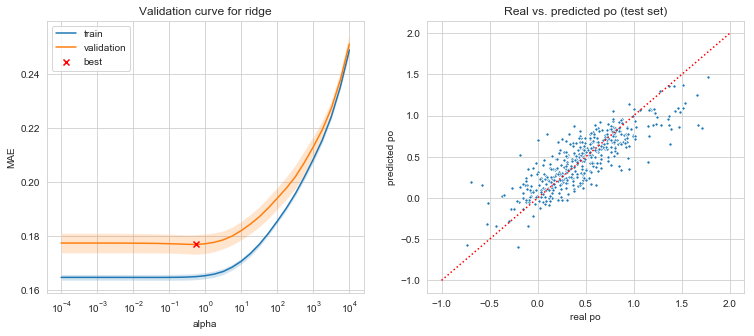

In [11]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, valid_scores = validation_curve(ridge, X_train, y_train, param_name="ridge__alpha",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge", param_range, -train_scores, -valid_scores, ax1)

sns.scatterplot(y_test, ridge_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

You can see that the MAEs do not change much for $alpha < 1$. As $alpha$ (and thus regularization strength) increases further, the performance starts to degrade quickly for both curves, because the model is underfitting.

### Third run (feature transformation with PowerTransformer)

This adds transformation with PowerTransformer for the skewed features. (Which features this applies to has been defined in the EDA). The purpose of this is to make the distribution of these features look more like a normal distribution, which improves the quality of the model.

First, using default $alpha = 1.0$.

In [12]:
preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_idxs),
    (PowerTransformer(), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

ridge2 = make_pipeline(preprocessor, Ridge())

ridge2.fit(X_train, y_train)
ridge2_test_pred = ridge2.predict(X_test)
print("Ridge2 MAE = {:.3f}".format(mean_absolute_error(y_test, ridge2_test_pred)))
print("Ridge2 R^2 = {:.3f}".format(ridge2.score(X_test, y_test)))

Ridge2 MAE = 0.154
Ridge2 R^2 = 0.749


That is a good improvement on the previous model (MAE 0.169 and R^2 0.694)!

### Fourth run (tune alpha)

Again, I use grid search with cross validation to find the optimal value for $alpha$.

In [13]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv2 = GridSearchCV(ridge2, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv2.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv2.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv2.best_score_))

Grid search / cross-validation:
Best alpha = 0.18
Best MAE = 0.165


In [14]:
gcv2_test_pred = gcv2.predict(X_test)
gcv2_test_mae = mean_absolute_error(y_test, gcv2_test_pred)
gcv2_test_r2 = r2_score(y_test, gcv2_test_pred)
print("On test data:")
print("Tuned Ridge2 MAE = {:.3f}".format(gcv2_test_mae))
print("Tuned Ridge2 R^2 = {:.3f}".format(gcv2_test_r2))
save_score("ridge", gcv2_test_mae, gcv2_test_r2, os.path.join("data","results", "model_scores.csv"))

On test data:
Tuned Ridge2 MAE = 0.153
Tuned Ridge2 R^2 = 0.749


The found value for $alpha$ is 0.18, which is somewhat smaller than in the previous model (meaning weaker regularization). Nonetheless, the model's performance on the test data is practically unchanged compared to default $alpha = 1.0$.

### Validation curve

Plot the validation curve again for the model with PowerTransformer to study the impact of the regularization strength $alpha$ on the model's performance.

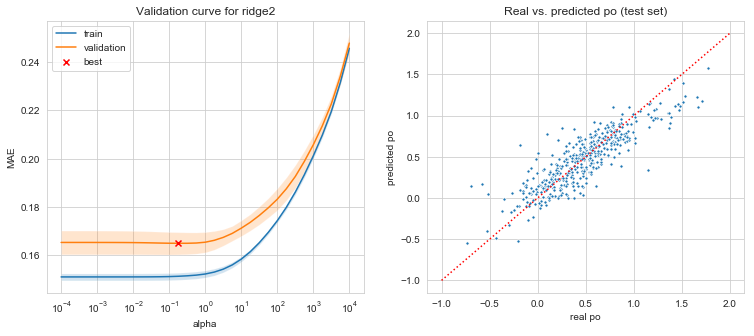

In [15]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, valid_scores = validation_curve(ridge2, X_train, y_train, param_name="ridge__alpha",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge2", param_range, -train_scores, -valid_scores, ax1)

sns.scatterplot(y_test, ridge2_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

The validation curve looks the same as before (but with reduced error). The MAEs do not change much for $alpha < 1$ but then start to increase quickly.

The model seems to underestimate (i.e. predict too centric) the po_value for communes that are on the right edge politically (po_value > 1.2) as well as overestimate (i.e. predict too centric) the po_value for the few communes that are on the left edge politically (po_value < -0.5).

## Feature importance

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html  
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#permutation-importance-with-multicollinear-or-correlated-features

I want to find out which features are the most important for the model. For that purpose I use the permutation_importance function of scikit-learn. It works like this:
- take a fitted model and test data
- compute the model score on the unchanged the test data (base score)
- for each feature (repeat several times and average)
    - randomly shuffle the values of that feature
    - compute the model score on the shuffled test data
    - compute the feature importance as difference between base score and shuffled score (how much worse did the predictions get when "destroying" that feature)
- rank the features by their importance

The method does have the drawback that collinear features appear less important because the model can compensate the "loss" of one feature with the other feature.

### With all features

In [16]:
preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_idxs),
    (PowerTransformer(), skewed_idxs),
    (StandardScaler(), skewed_idxs + unskewed_idxs),
    remainder = "passthrough"
)

estimator = make_pipeline(preprocessor, Ridge(alpha=0.18, random_state=0))
estimator.fit(X_train, y_train)
perm_importances = permutation_importance(estimator, X_train, y_train, scoring='neg_mean_absolute_error',
                                          n_repeats=10, n_jobs=12, random_state=0)

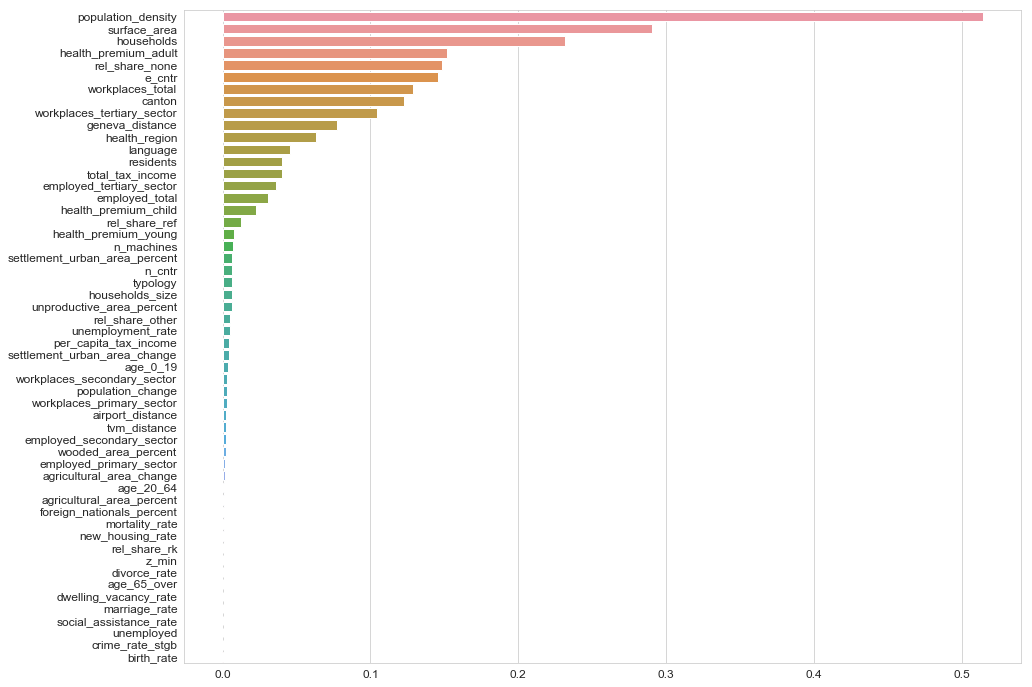

In [17]:
perm_sorted_idx = (-perm_importances["importances_mean"]).argsort()
perm_importances_sorted = perm_importances["importances_mean"][perm_sorted_idx]
cols_sorted = df_train.drop(columns="po_value").columns[perm_sorted_idx]

plt.figure(figsize = (15,12))
bp = sns.barplot(x=perm_importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

- according to this, about one third of the features seems important; but remember the disclaimer about collinearity
- features that I expected to be important (because of their correlation with the target) are indeed amongst the important ones:
    - canton
    - language
    - health_premium
    - e_cntr
- but I am surprised these seem to be not important:
    - unemployment_rate (note: same cluster as health_premium and e_cntr)
    - foreign_nationals_percent (note: same cluster as population_density)
- and I am surprised that these seem important (although they have low correlation):
    - surface_area
    - households, residents, workplaces_total, employed_total, workplaces_tertiary_sector, employees_tertiary_sector (same cluster)

Summary:

I do not trust that ranking very much. I suppose it is somewhat random how the model distributes the "importance" over the features of a cluster. For example, in the urbanity cluster, population_density looks very important, others unimportant. In the residents cluster on the other hand, several features look important.

So to pick a subset of features for a smaller model, one has to consider the clusters.

### With reduced feature set

The aim of this step is to build a model on around one dozen features (I have 11 clusters of features, plus categorical features). I start with one feature from each cluster and I also add canton, language and typology (categorical).

How to choose a feature from a cluster? As a heuristic, I prefer features with higher correlation to the target and I prefer features that represent a more general concept (e.g. residents 17 over workplaces_tertiary_sector 17).

I excluded some features from the set after manually checking that their removal has no effect or just a small effect on the model performance. These are the features that are commented out below.

In [18]:
reduced_features = [
    'residents', # Residents cluster
    'workplaces_primary_sector', # Primary sector cluster
    # 'population_density', # Urbanity cluster
    'health_premium_young', # Health premium cluster
    'rel_share_ref', # Religion cluster
    'per_capita_tax_income', # Mountains cluster
    "n_cntr", # 'rel_share_none', # No religion cluster
    # 'age_0_19', # Age cluster
    # 'agricultural_area_percent', # Farm/forest cluster
    # 'dwelling_vacancy_rate', # Useless "cluster"
    # 'population_change', # Useless "cluster"
    # categorical features
    'canton',
    'language',
    'typology'
]

X_train_red = df_train[reduced_features].values
X_test_red = df_test[reduced_features].values

categorical_features_red = set(categorical_features).intersection(set(reduced_features))
skewed_features_red = set(skewed_features).intersection(set(reduced_features))
unskewed_features_red = set(unskewed_features).intersection(set(reduced_features))

# print("categorical_features_red =", categorical_features_red)
# print("skewed_features_red =", skewed_features_red)
# print("unskewed_features_red =", unskewed_features_red)

categorical_idxs_red = cols_idxs(df[reduced_features], categorical_features_red)
skewed_idxs_red = cols_idxs(df[reduced_features], skewed_features_red)
unskewed_idxs_red = cols_idxs(df[reduced_features], unskewed_features_red)

# print("categorical_idxs_red = ", categorical_idxs_red)
# print("skewed_idxs_red = ", skewed_idxs_red)
# print("unskewed_idxs_red = ", unskewed_idxs_red)

In [19]:
preprocessor_red = make_column_transformer(
    (OneHotEncoder(), categorical_idxs_red),
    (PowerTransformer(), skewed_idxs_red),
    (StandardScaler(), skewed_idxs_red + unskewed_idxs_red),
    remainder = "passthrough"
)

ridge2_red = make_pipeline(preprocessor_red, Ridge())

parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv2_red = GridSearchCV(ridge2_red, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12)
gcv2_red.fit(X_train_red, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.4f}".format(gcv2_red.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv2_red.best_score_))

Grid search / cross-validation:
Best alpha = 0.0562
Best MAE = 0.175


In [20]:
gcv2_red_test_pred = gcv2_red.predict(X_test_red)
gcv2_red_test_mae = mean_absolute_error(y_test, gcv2_red_test_pred)
gcv2_red_test_r2 = r2_score(y_test, gcv2_red_test_pred)
print("On test data:")
print("Ridge (red.) MAE = {:.3f}".format(gcv2_red_test_mae))
print("Ridge (red.) R^2 = {:.3f}".format(gcv2_red_test_r2))
save_score("ridge_red", gcv2_red_test_mae, gcv2_red_test_r2, os.path.join("data","results", "model_scores.csv"))

On test data:
Ridge (red.) MAE = 0.159
Ridge (red.) R^2 = 0.728


Considering that I have reduced the number of features from 54 to 9, the performance of the model using the reduced feature set is not much worse than the model with all features:  

| &nbsp; | full | red. |
| --- | --- | --- |
|MAE|0.153|0.158|
|$R^2$|0.749|0.728|


In [21]:
perm_importances_red = permutation_importance(gcv2_red, X_train_red, y_train, scoring='neg_mean_absolute_error',
                                              n_repeats=10, n_jobs=12, random_state=0)

In [22]:
perm_sorted_idx = (-perm_importances_red["importances_mean"]).argsort()
perm_importances_sorted = perm_importances_red["importances_mean"][perm_sorted_idx]
cols_sorted = df[reduced_features].columns[perm_sorted_idx]

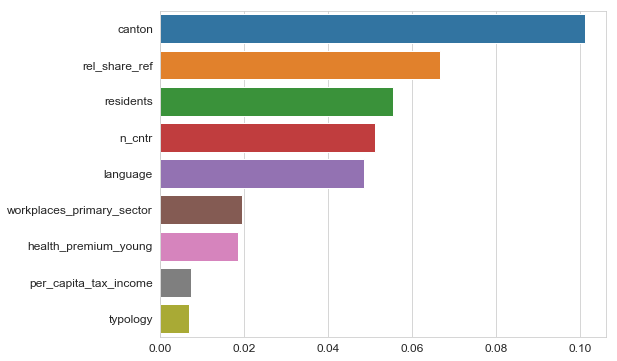

In [23]:
plt.figure(figsize = (8,6))
bp = sns.barplot(x=perm_importances_sorted, y=cols_sorted)
bp.tick_params(labelsize="large")

Summary: Using hierarchical clustering on the features, I constructed a model with only 9 features with performance close to the full-featured model. The chosen features represent distinctive concepts like geography, population size, economy, language, health or religion.